In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive'

/content/drive/MyDrive


In [ ]:
%pip install tensorflow-transform

     |████████████████████████████████| 406 kB 4.8 MB/s 
     |████████████████████████████████| 19.0 MB 19 kB/s 
     |████████████████████████████████| 48 kB 6.1 MB/s 
     |████████████████████████████████| 9.7 MB 65.5 MB/s 
     |████████████████████████████████| 17.7 MB 77 kB/s 
     |████████████████████████████████| 189 kB 65.3 MB/s 
     |████████████████████████████████| 829 kB 64.7 MB/s 
     |████████████████████████████████| 62 kB 952 kB/s 
     |████████████████████████████████| 2.3 MB 51.0 MB/s 
     |████████████████████████████████| 151 kB 73.2 MB/s 
     |████████████████████████████████| 435 kB 58.1 MB/s 
     |████████████████████████████████| 267 kB 63.9 MB/s 
     |████████████████████████████████| 183 kB 72.9 MB/s 
     |████████████████████████████████| 173 kB 60.8 MB/s 
     |████████████████████████████████| 255 kB 62.0 MB/s 
     |████████████████████████████████| 144 kB 72.7 MB/s 
     |████████████████████████████████| 169 kB 64.6 MB/s 
     |███████████████

In [ ]:
from __future__ import division, annotations

import os
import sys
import time
import datetime
import pickle
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import sklearn
from sklearn import metrics
import tensorflow as tf
import tensorflow_transform as tft
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Activation, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, ResNet50V2
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [ ]:
# load the best model to use for predictions
best_model = tf.keras.models.load_model('/content/drive/MyDrive/best_model.h5')
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 8) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 2336        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
def predict_input(fileNames):
    '''
    Args
    - fileNames: list of str, or a tf.Tensor (e.g. tf.placeholder) of str
        - path(s) to TFRecord files/dataset containing satellite images
    '''

    dataset = tf.data.TFRecordDataset(fileNames, compression_type='GZIP')
    bands = ['RED', 'BLUE', 'GREEN', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR', 'NIGHTLIGHTS']

    feature_columns = {x: tf.io.FixedLenFeature([255 * 255], dtype=tf.float32) for x in bands}
  
    def parse(example_proto):
        '''
        Args
        - example_proto: a tf.train.Example protobuf
        Returns: dict {'images': img, 'labels': label, 'locs': loc, 'years': year, ...}
        - img: tf.Tensor, shape [224, 224, channel], type float32
          - channel order is [R, B, G, SWIR1, SWIR2, TEMP1, NIR, NIGHTLIGHTS]
        - label: tf.Tensor, scalar or shape [1], type float32
        '''
        
        ex = tf.io.parse_single_example(example_proto, feature_columns)
        for band in bands:
            ex[band].set_shape([255 * 255])
            ex[band] = tf.reshape(ex[band], [255, 255])[15:-16, 15:-16]
            ex[band] = tf.nn.relu(ex[band])  
            ex[band] = tft.scale_to_z_score(ex[band])
        
        return ex
 
    def stack_images(features):
        '''Converts a dictionary of tensors to a tuple of (inputs).
        Turn the tensors returned by parse into a stack of shape (Height, Width, Channel).
        Args:
        - features: parsed examples returned from parse function
        Returns:
        - A tuple of (inputs).
        ''' 
        nfeat = tf.transpose(tf.squeeze(tf.stack(list(features.values()))))    
        return nfeat
      
    dataset = dataset.map(parse, num_parallel_calls=4)
    dataset = dataset.map(stack_images, num_parallel_calls=4)
    dataset = dataset.batch(1)
        
    return dataset

In [ ]:
predict_db = predict_input(fileNames='/content/drive/My Drive/datasets/testset.tfrecord.gz')
predictions = best_model.predict(predict_db)

In [ ]:
def get_groundtruth(fileNames):  
    dataset = tf.data.TFRecordDataset(fileNames, compression_type='GZIP')      
    feature_column = {'wealthpooled': tf.io.FixedLenFeature((), dtype=tf.float32)}
    
    def parse_label(example_proto):
        parsed_labels = tf.io.parse_single_example(example_proto, feature_column)
        return parsed_labels

    dataset = dataset.map(parse_label, num_parallel_calls=4)
    dataset = dataset.batch(1)
    
    return dataset

ground_truth = get_groundtruth(fileNames='/content/drive/My Drive/datasets/testset.tfrecord.gz')
groundtruth = tfds.as_numpy(ground_truth)

y_true = []
for x in groundtruth:
    y_true.append(x['wealthpooled'][0])

y_true = np.array(y_true)

In [ ]:
predictions_df = pd.DataFrame()
predictions_df['Ground Truth'] = y_true
predictions_df['Predictions'] = predictions
#predictions_df.to_csv('/content/drive/My Drive/actual_predicted.csv')
predictions_df.head()

,Ground Truth,Predictions
0,1.497489,0.725349
1,-0.207140,-0.214923
2,-0.580833,-0.957796
3,1.513144,0.805557
4,0.176225,-0.258435


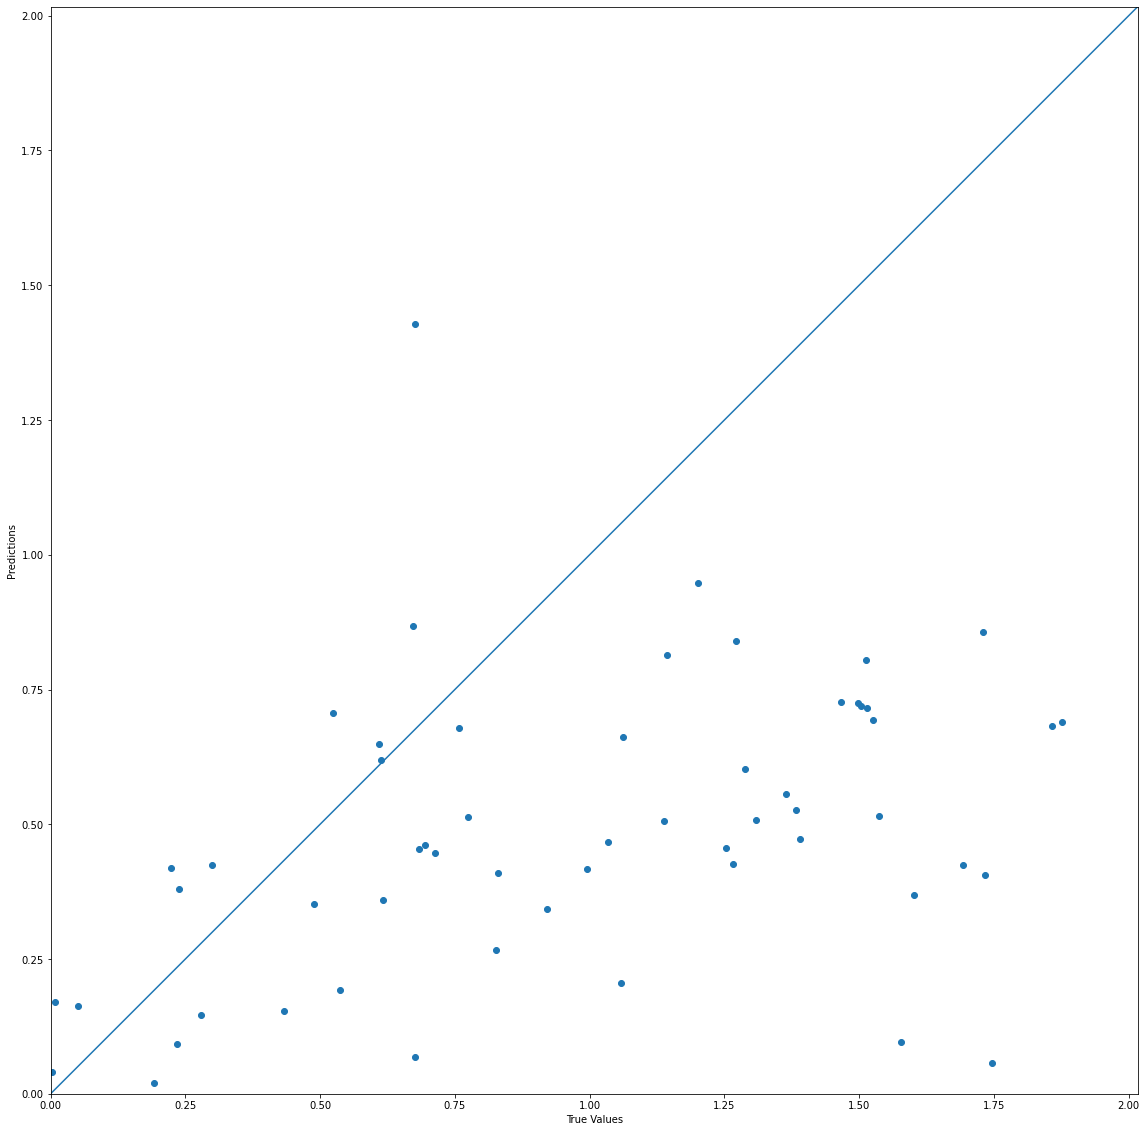

In [ ]:
plt.figure(figsize=(20, 20))
plt.scatter(y_true, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

In [ ]:
loss = tf.reduce_mean(tf.losses.mean_squared_error(y_true, predictions))
loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.56921333>

# conclusion:

- In overall the model obtained a mean squared error of 0.57 which implies that on average the model is off by at least 57% in predicting poverty. Clearly that's a pretty poor result.

So what exactly does it mean? 

- Well it could mean a few things: Say maybe we need to train the model on more data to improve it prediction power, or maybe tweak a few parameters and remove some noise, etc.
- While all these could be considered valid, what mostly this means is that these sattelite images don't necessarily correlate to the statistics on headcount poverty rates, urbanization, agriculture, or income inequality. There is more to asset wealth than just what the imagery captures i.e key livelihood outcomes often measured in surveys are distributed within households, or between households within villages and are very difficult to observe in imagery and therefore, it shouldn’t be much of a surprise our model did not perform that well.
- Some problems with the model's perfomance may also likely be due to other sources of noise in the survey data e.g survey recall bias, sampling variations or geographical inaccuracies. 
- That said, the model seems scalable and maybe with a few improvements, it could be used to generate wealth estimates in data poor environments which could be used to help target social programs in these environments as well as to understand the determinants of variations in well-being across not only Kenya, but the developing world.
- Some key areas of improvement however would be improving the interpretability of deep learning models in this context, and in developing approaches to navigate this apparent performance-interpretability tradeoff.
- This approach could also be applied to the measurement of other key outcomes, including other key livelihood indicators such as health outcomes and the performance in these related domains will depend highly on both the availability and quality of training data, which remains limited. 
- The model could also further improve by the incorporating of higher resolution optical and radar imagery or in combination with data from
other passive sensors such as mobile phones or social media. All representing scalable opportunities to expand the accuracy and timeliness of data on key economic indicators in the Kenya, and could accelerate progress towards measuring and achieving global development goals.